### Daytum +2 Course: Data Analytics, Geostatistics and Machine Learning Deep Dive

### Artificial Neural Net Demonstration and Exercise

#### Goal

Reservoir property estimation from seismic information with artificial neural nets.

#### Description

Here's a simple, documented workflow, demonstration of reservoir property estimation from seismic information with artificial neural nets for subsurface modeling workflows. This should help you get started with building subsurface models that integrate machine learning to integrate data sources. 

#### Artificial Neural Networks

Machine learning method for supervised learning for classification and regression analysis.  Here are some key aspects of support vector machines.

**Basic Design** *"...a computing system made up of a number of simple, highly interconnected processing elements, which process information by their dynamic state response to external inputs."* Caudill (1989). 

**Nature-inspire Computing** based on the neuronal structure in the brain, including many interconnected simple, processing units, known as nodes that are capable of complicated emergent pattern detection due to a large number of nodes and interconnectivity.

**Training and Testing** just like and other predictive model (e.g. linear regression, decision trees and support vector machines) we perform training to fit parameters and testing to tune hyper parameters.

**Parameters** are the weights applied to each connection and a bias term applied to each node.  For a single node artificial neural network, we could compare the weights to the $\beta$ slope term and the bias to the $\beta_{0}$ intercept term.

\begin{equation}
Y = \beta X + \beta_0
\end{equation}

the number of parameters increases rapidly as we increase the number of nodes and the connectivity between the nodes.

**Layers** the typical artificial neural net is structured with an **input layer**, with one node for each $m$ predictor feature, $X_1,\ldots,X_m$. There is an **ouput layer**, with one node for each $r$ response feature, $Y_1,\ldots,Y_r$.  There may be one or more layers of nodes between the input and output layers, known as **hidden layer(s)**.  

**Connections** are the linkages between the nodes in adjacent layers.  For example, in a fully connected artificial neural network, all the input nodes are connected to all of the nodes in the first layer, then all of the nodes in the first layer are connected to the next layer and so forth. Each connection includes a weight parameter as indicated above.

**Nodes** receive the weighted signal from the connected previous layer nodes, sum and then apply this result to the **activation** function in the node. Some example activation functions include:

* **Binary** the node fires or not.  This is represented by a Heaviside step function.

* **Identify** the input is passed to the output $f(x) = x$

* **Linear** the node passes a signal that increases linearly with the weighted input.

* **Logistic** also known as sigmoid or soft step $f(x) = \frac{1}{1+e^{-x}}$

the result of the linearly weighted inputs applied to the nonlinear activation is output from the node to the next layer of connected nodes.

**Training Cycles / Epochs** include the presentation of new data, forward application of the current prediction model to make estimates, calculation of error and then backpropagation of error to correct the network weights to reduce the error.

**Batch** is the set of training data drawn to train for each epoch. There is a trade-off, a larger batch results in more computational time per epoch, but a more accurate estimate of the error to adjust the weights.  Smaller batches result in a nosier estimate of the error, but faster epochs, this results in faster learning and even possibly more robust models.

**Local Minimums** if one calculated the error hypersurface for a range of model parameters it would be hyparabolic, there is a global minimium error solution.  But this error hyper surface is rough and it is possible to be stuck in a local minimum. **Learning Rate** and **Mommentum** coefficients are introduced to avoid getting stuck in local minimums.

* **Mommentum** is a hyperparameter to control the use of information from the weight update over the last epoch for consideration in the current epoch.  This can be accomplished with an update vector, $v_i$, a mommentum parameter, $\alpha$, to calculate the current weight update, $v_{i+1}$ given the new update $\theta_{i+1}$.

\begin{equation}
v_{i+1} = \alpha v_i + \theta_{i+1}
\end{equation}

* **Learning Rate** is a hyperparameter that controls the adjustment of the weights in response to the gradient indicated by backpropagation of error 

##### Applications to subsurface modeling

We demonstrate the estimation of porosity between wells from seismic accoustic impedance. 

* modeling a nonlinear relationship between acoustic impedance and porosity 

#### Limitations of Neural Network Estimation

Since we demonstrate the use of a neural network to estimate porosity inter-well from seismic, we should comment on limitations of neural networks for estimation:

* does not honor the well data

* does not honor the histogram of the data

* does not honor spaital correlation 

* does not honor the multivariate relationship

* generally low interpretability models

* requires a large number of data for effective training

* high model complexity with high model variance


#### Workflow Goals

Learn the basics of machine learning in python to predict subsurface features. This includes:

* Loading and visualizing sample data
* Trying out neural nets 

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import matplotlib.pyplot as plt           # for plotting
import seaborn as sns                     # for plotting
import warnings                           # supress warnings from seaborn pairplot
from sklearn.model_selection import train_test_split # train / test DatFrame split
from intake import cat

We will also need the following packages to train and test our artificial neural nets:

* Tensorflow - open source machine learning 

* Keras - high level application programing interface (API) to build and train models

* This workflow was designed with tensorflow version 1.13.1 and does not work with version 2.0.0 alpha.

To check your current version of tensorflow you could run the next block of code.

In [3]:
import tensorflow as tf
tf.__version__                            # check the installed version of tensorflow

'1.13.1'

Let's import all of the tensorflow and keras methods that we will need in our workflow.

In [4]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
import keras
from tensorflow.python.keras import backend as k

Using TensorFlow backend.


#### Loading Data
Let's load the provided multivariate, spatial data source `sample_data_12`.  It is a comma delimited file with: 

* X and Y coordinates ($m$)
* facies 0 and 1 
* porosity (fraction)
* permeability ($mD$)
* acoustic impedance ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$). 

Let's run this command to load the data and then look at the resulting DataFrame to ensure that we loaded it. 

In [5]:
df = cat.sample_data_12.read()     # load our data table (wrong name!)
df = df.sample(frac=.30, random_state = 73073); df = df.reset_index()
df['logPerm'] = np.log10(df['Perm'].values)

Let's add a facies label for shale and sand.

In [6]:
df['Facies_Label']=np.zeros(len(df));
df['Facies_Label']= np.where(df['Facies']==1, 'Sand', 'Shale')

Let's get a quick preview of our new DataFrame, 'df' with the built in function.

```python
df.head()
```

In [7]:
df.head(n=13)

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,logPerm,Facies_Label
0,72,94,250.0,50.0,0.0,0.139637,0.347182,4747.274043,-0.459442,Shale
1,153,232,650.0,750.0,0.0,0.170732,10.720560,4535.625583,1.030217,Shale
2,258,439,80.0,669.0,1.0,0.244345,3222.716042,2696.102930,3.508222,Sand
3,56,73,200.0,150.0,0.0,0.167125,3.042590,5500.997419,0.483243,Shale
4,303,521,60.0,929.0,1.0,0.216253,400.298484,3959.934912,2.602384,Sand
5,374,645,750.0,699.0,0.0,0.159171,9.224292,5263.064063,0.964933,Shale
6,333,571,340.0,549.0,0.0,0.170881,84.471492,2918.232227,1.926710,Shale
7,1,2,50.0,850.0,1.0,0.237154,39.837129,3074.562617,1.600288,Sand
8,54,71,200.0,250.0,1.0,0.188043,57.804784,4997.078597,1.761964,Sand
9,311,535,250.0,579.0,1.0,0.215039,625.510541,2693.691341,2.796235,Sand


#### Summary Statistics for Tabular Data

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,144.0,261.048611,136.830267,1.000000,144.750000,270.000000,381.250000,478.000000
Unnamed: 0,144.0,440.291667,245.046303,2.000000,217.250000,459.000000,659.250000,825.000000
X,144.0,449.375000,263.691435,0.000000,242.500000,400.000000,650.000000,980.000000
Y,144.0,542.979167,289.228936,19.000000,300.000000,579.000000,800.000000,979.000000
Facies,144.0,0.659722,0.475456,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,144.0,0.190700,0.031972,0.131230,0.166621,0.188733,0.217234,0.256172
Perm,144.0,510.036736,1136.459068,0.039555,6.950509,56.886770,356.658709,7452.343369
AI,144.0,3746.825725,793.196589,1961.600397,3167.631744,3668.526774,4244.264532,6194.573653
logPerm,144.0,1.646059,1.210694,-1.402796,0.841941,1.754955,2.552252,3.872293


From this table we set some reasonable feature ranges for plotting.

In [9]:
pormin = 0.13; pormax = 0.26              # porosity min and max
permmin = 0.01; permmax = 3000            # permeability min and max
AImin = 1000.0; AImax = 8000              # acoustic impedance min and max
Fmin = 0; Fmax = 1                        # facies min and max
cmap = plt.cm.plasma                      # color map for plotting

#### Seismically-Derived Map

Let's load a seismically-derived map of acoustic impedance.

* This seismic acoustic impedance matches the well data acoustic impedance at the well locations

* This seismic data has better coverage than the well data, but with larger scale and error

In [10]:
seismic = np.loadtxt('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/AI_grid.csv', delimiter=",")

Let's set the map parameters:

* X min and max

* Y min and max

* number of cells in the X and Y directions

* isotropic cell size

and then plot the loaded seismic map.

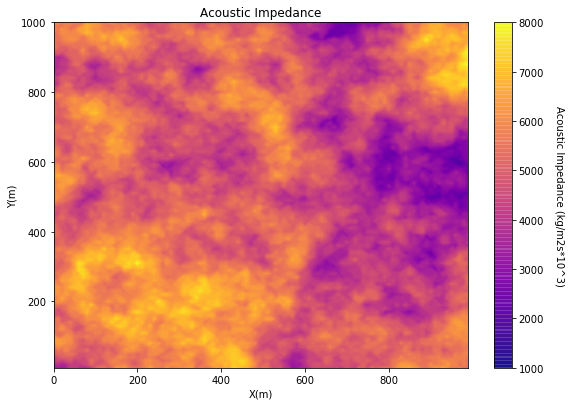

In [11]:
xmin = 0.0; xmax = 1000.0                 # range of x values
ymin = 0.0; ymax = 1000.0                 # range of y values
ny = 100; nx = 100                        # number of cell in Y and X
cell_size = 10.0;                         # grid cell size

plt.subplot(111)
GSLIB.pixelplt_st(seismic,xmin,xmax,ymin,ymax,cell_size,AImin,AImax,'Acoustic Impedance','X(m)','Y(m)','Acoustic Impedance (kg/m2s*10^3)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Extract Variables of Interest

Let's extract the facies, porosity, log permeability and acoustic impedance.

* the extracted DataFrame subset is a shallow copy, any changes in DataFrame 'df_subset' update the same entries in 'df'.

In [12]:
df_subset = df.iloc[:,[3,4,7,6]]

Always good to preview the DataFrame everytime we work with it to make sure it is correct.

In [13]:
df_subset.head(n=13)

,Y,Facies,AI,Perm
0,50.0,0.0,4747.274043,0.347182
1,750.0,0.0,4535.625583,10.720560
2,669.0,1.0,2696.102930,3222.716042
3,150.0,0.0,5500.997419,3.042590
4,929.0,1.0,3959.934912,400.298484
5,699.0,0.0,5263.064063,9.224292
6,549.0,0.0,2918.232227,84.471492
7,850.0,1.0,3074.562617,39.837129
8,250.0,1.0,4997.078597,57.804784
9,579.0,1.0,2693.691341,625.510541


#### Multivariate Relationships

Before we build a predictive model, it is a good idea to attempt to understand the multivariate relationships between the variables. Let's calculate a matrix scatter plots to understand how the data parameters are correlated to each other, 2 variables at a time: 

* linearility vs. non-linearity

* homo- vs. heteroscedasticity, 

* constraints

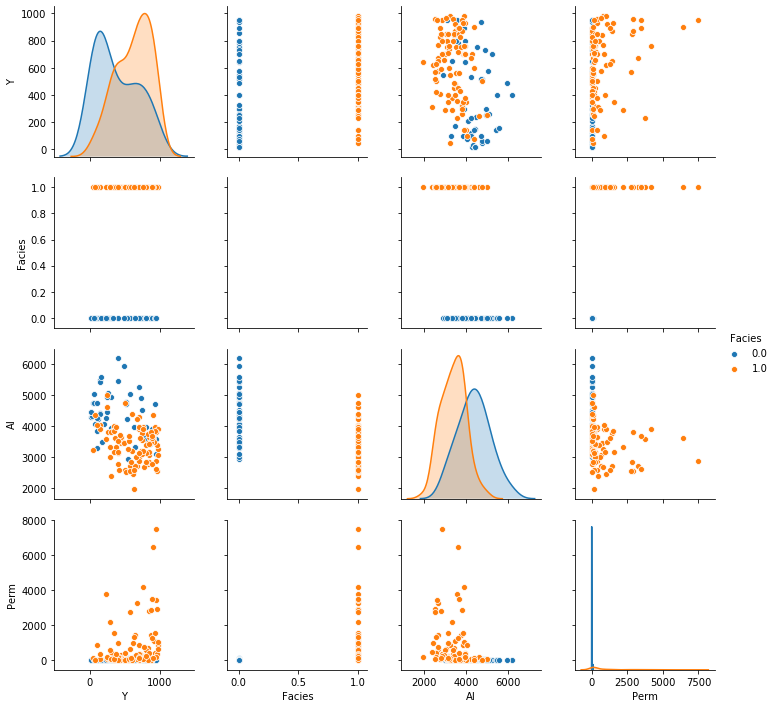

In [14]:
warnings.filterwarnings('ignore')         # supress warning from the seaborn.pairplot         
sns.pairplot(df_subset, hue = 'Facies')
sns.set(style="ticks")
plt.show()

#### Data Normalization

We must normalize the features before we apply them in a neural network model.

* We will set the features to range from -1 to 1.

These are the motivations for this normalization:

* remove effect of scale of different type of data (i.e., acoustic impedance varies between 2000~6000 but porosity only varies between 0~0.3)

* activation functions in Neural networks have more sensivity when the values of nodes are closer to 0.0 (i.e., results in higher gradient and improves backpropagation in training)

Let's normalize each feature.  

* It is easy to backtransform given we keep track of the original min and max values

In [15]:
por_min = df['Porosity'].min(); por_max = df['Porosity'].max();
logperm_min = df['logPerm'].min(); logperm_max = df['logPerm'].max();
AI_min = df_subset['AI'].min(); AI_max = df_subset['AI'].max();

df_subset['norm_Porosity'] = (df['Porosity'] - por_min)/(por_max - por_min) * 2 - 1
df_subset['norm_logPerm'] = (df['logPerm'] - logperm_min)/(logperm_max - logperm_min) * 2 - 1
df_subset['norm_AI'] = (df_subset['AI'] - AI_min)/(AI_max - AI_min) * 2 - 1

Let's check the update to our DataFrame with a quick preview.

In [16]:
df_subset.head(n=13)

,Y,Facies,AI,Perm,norm_Porosity,norm_logPerm,norm_AI
0,50.0,0.0,4747.274043,0.347182,-0.865422,-0.642337,0.316178
1,750.0,0.0,4535.625583,10.720560,-0.367672,-0.077546,0.216178
2,669.0,1.0,2696.102930,3222.716042,0.810690,0.861966,-0.652961
3,150.0,0.0,5500.997419,3.042590,-0.425413,-0.284926,0.672298
4,929.0,1.0,3959.934912,400.298484,0.361002,0.518526,-0.055825
5,699.0,0.0,5263.064063,9.224292,-0.552734,-0.102298,0.559879
6,549.0,0.0,2918.232227,84.471492,-0.365287,0.262351,-0.548010
7,850.0,1.0,3074.562617,39.837129,0.695581,0.138591,-0.474146
8,250.0,1.0,4997.078597,57.804784,-0.090559,0.199889,0.434206
9,579.0,1.0,2693.691341,625.510541,0.341574,0.592023,-0.654101


It is also a good idea to check the summary statistics.  

* All continuous features should now range from -1.0 to 1.0

In [17]:
df_subset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Y,144.0,542.979167,289.228936,19.000000,300.000000,579.000000,800.000000,979.000000
Facies,144.0,0.659722,0.475456,0.000000,0.000000,1.000000,1.000000,1.000000
AI,144.0,3746.825725,793.196589,1961.600397,3167.631744,3668.526774,4244.264532,6194.573653
Perm,144.0,510.036736,1136.459068,0.039555,6.950509,56.886770,356.658709,7452.343369
norm_Porosity,144.0,-0.048027,0.511789,-1.000000,-0.433483,-0.079520,0.376700,1.000000
norm_logPerm,144.0,0.155945,0.459023,-1.000000,-0.148929,0.197231,0.499519,1.000000
norm_AI,144.0,-0.156515,0.374770,-1.000000,-0.430173,-0.193509,0.078516,1.000000


#### Separation of Training and Testing Data

We also need to split our data into training / testing datasets so that we:

* can train our neural networks using training data 

* while testing their performance with validating data.

In [18]:
X = df_subset.iloc[:,[6]]                 # extract the predictor feature - acoustic impedance
y = df_subset.iloc[:,[4]]                 # extract the response feature - porosity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73073)

Let's visualize are train and test data split on a single scatter plot.

* we want to make sure it is fair

* ensure that the test samples are not clustered or too far away from the training data.

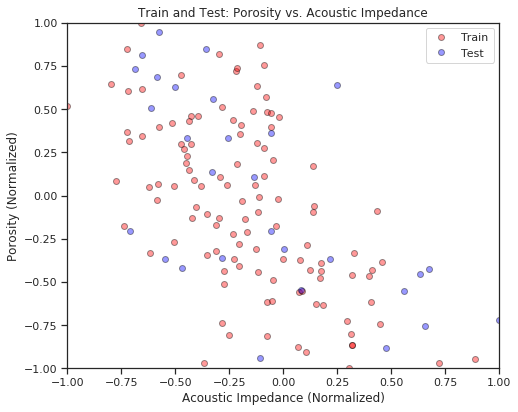

In [19]:
plt.subplot(121)
plt.plot(X_train['norm_AI'].values,y_train['norm_Porosity'].values, 'o', markerfacecolor='red', markeredgecolor='black', alpha=0.4, label = "Train")
plt.plot(X_test['norm_AI'].values,y_test['norm_Porosity'].values, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=0.4, label = "Test")
plt.legend(loc='upper right');
plt.title('Train and Test: Porosity vs. Acoustic Impedance')
plt.ylabel('Porosity (Normalized)')
plt.xlabel('Acoustic Impedance (Normalized)')
plt.xlim(-1,1); plt.ylim(-1,1)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Build and Train a Simple Neural Network

For our first model let's try something very simple.  

* 1 predictor feature - acoustic impedance

* 1 responce feature - porosity

We will build a model to predict porosity from acoustic impedance over all locations in our model $\bf{u} \in AOI$. 

\begin{equation}
\phi(\bf{u}) = \hat{f}(AI(\bf{u})
\end{equation}

We will use this model to inform porosity between the wells.

In [20]:
# Build Neural Network for prediction model (input: AI - > Output: Porosity)
model_1 = Sequential([
    Dense(1, activation='relu', input_shape=(1,)),
    Dense(3, activation='relu'),
    Dense(1, activation='tanh'),
])

Instructions for updating:
Colocations handled automatically by placer.


We have specified a simple neural net with:

* 1 input node 

* 3 nodes in the hidden layer

* 1 output node

Now we specify the optimization method and the related hyperparameters (e.g.,learning rate, etc)
further information of Keras optimizers are available [here](https://keras.io/optimizers).

In [21]:
keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_1.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

We are ready to supply our normalized predictor feature to predict the normalized responce feature.

In [22]:
hist_1 = model_1.fit(X_train, y_train,
          batch_size=5, epochs=300,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 115 samples, validate on 29 samples
Epoch 1/300
115/115 [==============================] - 1s 6ms/step - loss: 0.2280 - acc: 0.0000e+00 - val_loss: 0.2788 - val_acc: 0.0000e+00
Epoch 2/300
115/115 [==============================] - 0s 1ms/step - loss: 0.2245 - acc: 0.0000e+00 - val_loss: 0.2766 - val_acc: 0.0000e+00
Epoch 3/300
115/115 [==============================] - 0s 924us/step - loss: 0.2212 - acc: 0.0000e+00 - val_loss: 0.2741 - val_acc: 0.0000e+00
Epoch 4/300
115/115 [==============================] - 0s 911us/step - loss: 0.2184 - acc: 0.0000e+00 - val_loss: 0.2717 - val_acc: 0.0000e+00
Epoch 5/300
115/115 [==============================] - 0s 905us/step - loss: 0.2160 - acc: 0.0000e+00 - val_loss: 0.2695 - val_acc: 0.0000e+00
Epoch 6/300
115/115 [==============================] - 0s 897us/step - loss: 0.2134 - acc: 0.0000e+00 - val_loss: 0.2676 - val_acc: 0.0000e+00
Epoch 7/300
115/115 [==============================] 

Let's check the training curve, loss function for our model.

* this is a measure of the inaccuracy

* **square loss** ($L_2$ loss) is the:

\begin{equation}
L_2 = \sum_{\bf{u}_{\alpha} \in AOI} \left(y(\bf{u}_{\alpha}) - \hat{f}(x_1(\bf{u}_{\alpha}),\ldots,x_m(\bf{u}_{\alpha})\right)
\end{equation}

We can see the progress of the model over epochs in reduction of training and testing error.

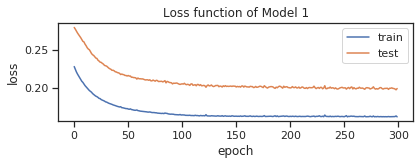

In [23]:
plt.subplot(2,1,1)
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Loss function of Model 1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

Let's visualize the model in prediction.

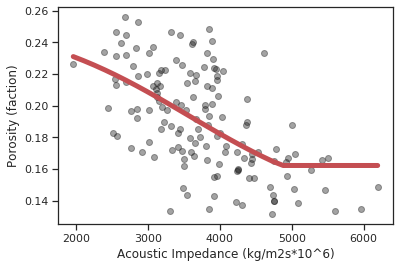

In [24]:
AIbins = np.linspace(df_subset['AI'].values.min(), df_subset['AI'].values.max(), 30) # set the bins for prediction
norm_AIbins = (AIbins-AI_min)/(AI_max-AI_min)*2-1 # use normalized bins

pred_norm_porsity = model_1.predict(np.array(norm_AIbins)) # predict with our ANN

pred_porosity = (pred_norm_porsity + 1)/2*(por_max - por_min)+por_min # transform it back to original range

plt.figure()
plt.plot(df_subset['AI'].values,df['Porosity'].values,'ko', alpha = 0.4)
plt.plot(AIbins,pred_porosity,'r-',linewidth=5)
plt.xlabel('Acoustic Impedance (kg/m2s*10^6)')
plt.ylabel('Porosity (faction)')
plt.show()

#### Neural Net-Based Map of Porosity from Seismic Acoustic Impedance

Now let's predict porosity at all locations from the seismic data. First we normalize the seismic data.  

* We may have some values below -1.0 and above 1.0 as we are using the transform applied to the acoustic impedance at the wells.  

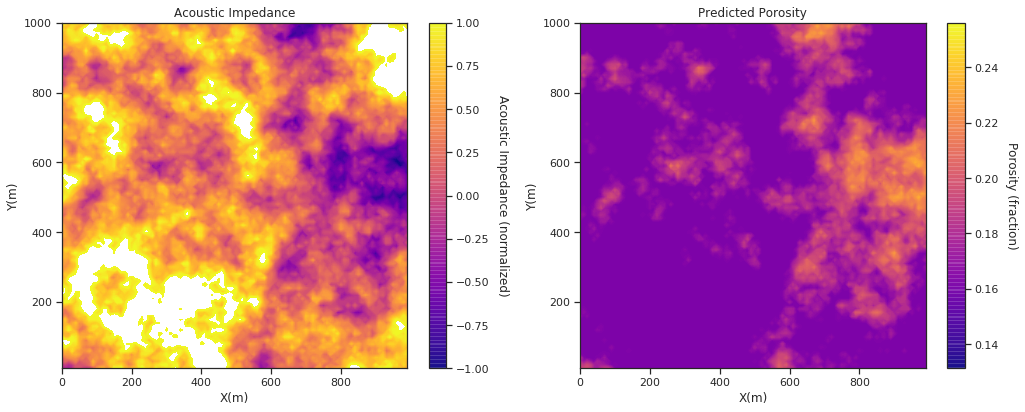

In [25]:
norm_seismic = (seismic-AI_min)/(AI_max-AI_min)*2-1

pred_norm_porosity_map = model_1.predict(np.array(norm_seismic.flatten())) # predict with our ANN

pred_porosity_map = (pred_norm_porosity_map + 1)/2*(por_max - por_min)+por_min # transform it back to original range
pred_porosity_map = np.reshape(pred_porosity_map,(ny,nx))

plt.subplot(121)
GSLIB.pixelplt_st(norm_seismic,xmin,xmax,ymin,ymax,cell_size,-1,1,'Acoustic Impedance','X(m)','Y(m)','Acoustic Impedance (normalized)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(pred_porosity_map,xmin,xmax,ymin,ymax,cell_size,por_min,por_max,'Predicted Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Visualizing the Neural Net

There are some methods available to interogate the artificial neural net.

* neural net summary

* weights

Here's the summary from our neural net.  It lists by layers the number of nodes and number of parameters.

In [26]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


We can also see the actual trained weights for each node in each layer.

In [27]:
# Weights of Model_1

for layer in model_1.layers:
    g = layer.get_config()
    h = layer.get_weights()
    print(g)
    print(h)
    print('\n')

{'name': 'dense_1', 'trainable': True, 'batch_input_shape': (None, 1), 'dtype': 'float32', 'units': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[-0.82729095]], dtype=float32), array([0.3067032], dtype=float32)]


{'name': 'dense_2', 'trainable': True, 'units': 3, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[-0.7

We can observe the weights and bias terms associate with our neural network.